In [1]:
import logging

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches
import numpy as np
from tqdm import tqdm
import seaborn as sns

from thesispy.experiments.validation import *
from thesispy.experiments.wandb_client import *
from thesispy.definitions import *
from thesispy.plot_utils import *

In [2]:
ds_1 = get_runs_as_dataset("learn_1_fair_comparison_final")
ds_2 = get_runs_as_dataset("learn_2_fair_comparison_final")
ds_3 = get_runs_as_dataset("learn_3_fair_comparison_final")

ds_1.save()
ds_2.save()
ds_3.save()

labels = ["ASGD", "GOMEA", "GOMEA-LS", "GOMEA-FC"]
patients = ["Patient 1", "Patient 2", "Patient 3"]

datasets = [ds_1, ds_2, ds_3]

In [ ]:
logger1 = logging.getLogger("WandbClient")
logger2 = logging.getLogger("Validation")
logger1.disabled = True
logger2.disabled = True

for ds in datasets:
    for run in tqdm(ds.runs, desc=f"Updating bending energy for runs from project {ds.project}"):
        run_result = get_run_result(ds.project, run.id)
        bending_energy_crude = bending_energy(run_result.dvf, 3, run_result.instance.mask, use_tqdm=False)
        run.summary["bending_energy_crude"] = bending_energy_crude
    ds.save()

logger1.disabled = False
logger2.disabled = False

In [3]:
main_df_list = []
df_lists = []
df_lists_mean = []
df_lists_std = []

for i, ds in enumerate(datasets):
    df = ds.aggregate(["Metric1Weight", "Optimizer", "OptimizerName", "UseASGD", "ComputeControlPointFolds"], ["metric0", "metric1", "SDLogJ", "bending_energy", "bending_energy_crude", "dice_similarity", "tre"])
    df = df.astype({"Metric1Weight": float, "Optimizer": str, "OptimizerName": str, "UseASGD": str, "ComputeControlPointFolds": str, "metric0": float, "metric1": float, "SDLogJ": float, "bending_energy": float, "bending_energy_crude": float, "dice_similarity": float, "tre": float})
    df["Instance"] = patients[i]

    asgd_mask = df["Optimizer"] == "AdaptiveStochasticGradientDescent"
    gomea_mask = (df["Optimizer"] == "GOMEA") & (df["UseASGD"] == "None") & (df["ComputeControlPointFolds"] == "None")
    gomea_ls_mask = (df["Optimizer"] == "GOMEA") & (df["UseASGD"] == "True") & (df["ComputeControlPointFolds"] == "None")
    gomea_fc_mask = (df["Optimizer"] == "GOMEA") & (df["UseASGD"] == "None") & (df["ComputeControlPointFolds"] == "True")

    df.loc[asgd_mask, "OptimizerName"] = "ASGD"
    df.loc[gomea_mask, "OptimizerName"] = "GOMEA"
    df.loc[gomea_ls_mask, "OptimizerName"] = "GOMEA-LS"
    df.loc[gomea_fc_mask, "OptimizerName"] = "GOMEA-FC"
    
    df["tre_dsc"] = df["tre"] / df["dice_similarity"]
    main_df_list.append(df)

    df_asgd = df.loc[asgd_mask]
    df_gomea = df.loc[gomea_mask]
    df_gomea_ls = df.loc[gomea_ls_mask]
    df_gomea_fc = df.loc[gomea_fc_mask]

    df_asgd = df_asgd.drop(columns=["Optimizer", "OptimizerName", "Instance", "UseASGD", "ComputeControlPointFolds"])
    df_gomea = df_gomea.drop(columns=["Optimizer", "OptimizerName", "Instance", "UseASGD", "ComputeControlPointFolds"])
    df_gomea_ls = df_gomea_ls.drop(columns=["Optimizer", "OptimizerName", "Instance", "UseASGD", "ComputeControlPointFolds"])
    df_gomea_fc = df_gomea_fc.drop(columns=["Optimizer", "OptimizerName", "Instance", "UseASGD", "ComputeControlPointFolds"])

    df_list_ = [df_asgd, df_gomea, df_gomea_ls, df_gomea_fc]
    df_list_mean_ = [df.groupby("Metric1Weight").mean() for df in df_list_]
    df_list_std_ = [df.groupby("Metric1Weight").std() for df in df_list_]
    
    df_lists.append(df_list_)
    df_lists_mean.append(df_list_mean_)
    df_lists_std.append(df_list_std_)

/tmp/ipykernel_14282/766255021.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in leg.legendHandles:


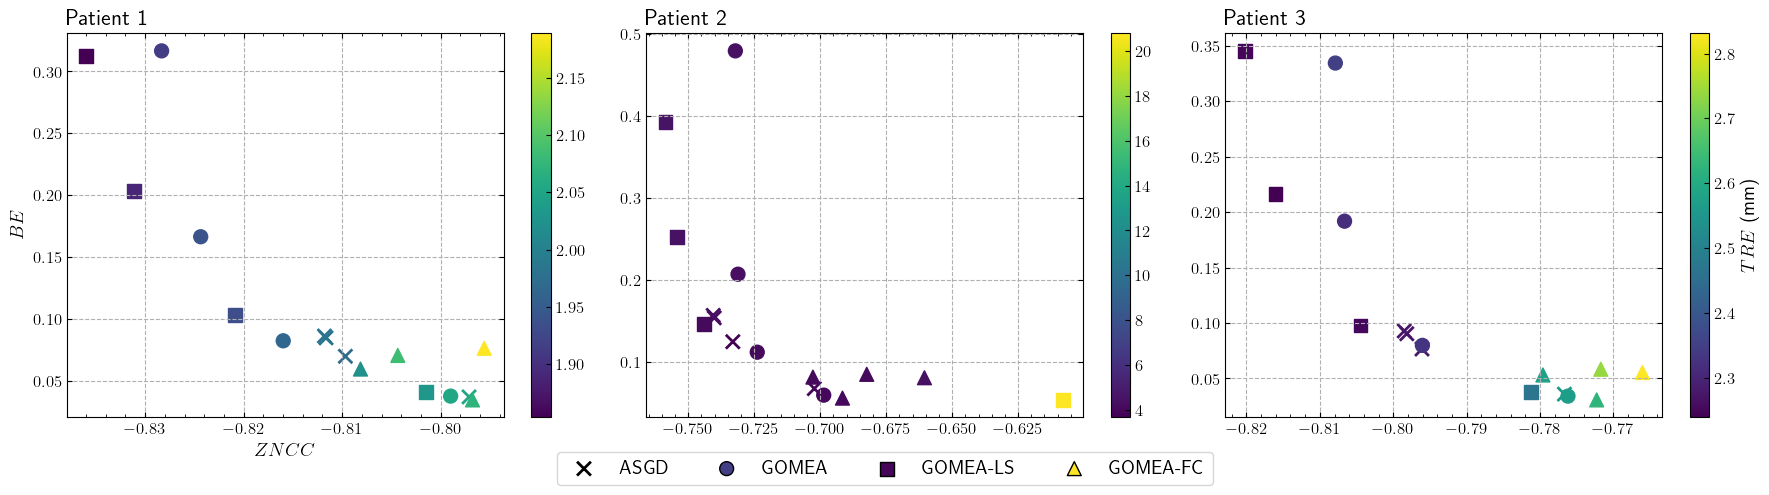

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

marker_size = 100
markers = ["x", "o", "s", "^"]

for i, df_list in enumerate(df_lists_mean):
    min_tre = np.min([np.min(df["tre"]) for df in df_list])
    max_tre = np.max([np.max(df["tre"]) for df in df_list])
    norm = mpl.colors.Normalize(vmin=min_tre, vmax=max_tre)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap="viridis"), ax=axes[i])

    if i == 2:
        cbar.set_label("$TRE$ (mm)")
    axes[i].set_title(patients[i])

    for j, df in enumerate(df_list):
        axes[i].scatter(df["metric0"], df["bending_energy_crude"], label=labels[j], marker=markers[j], s=marker_size, c=df["tre"], cmap="viridis", norm=norm)

axes[0].set_xlabel("$ZNCC$")
axes[0].set_ylabel("$BE$")

handles, labels = axes[2].get_legend_handles_labels()
leg = fig.legend(handles, labels, ncol=4, loc="lower center", prop={'size': 14})
for handle in leg.legendHandles:
    handle.set_facecolor("black")
    handle.set_edgecolor("black")
    handle.set_color("black")

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.savefig("pareto_fronts.pdf")

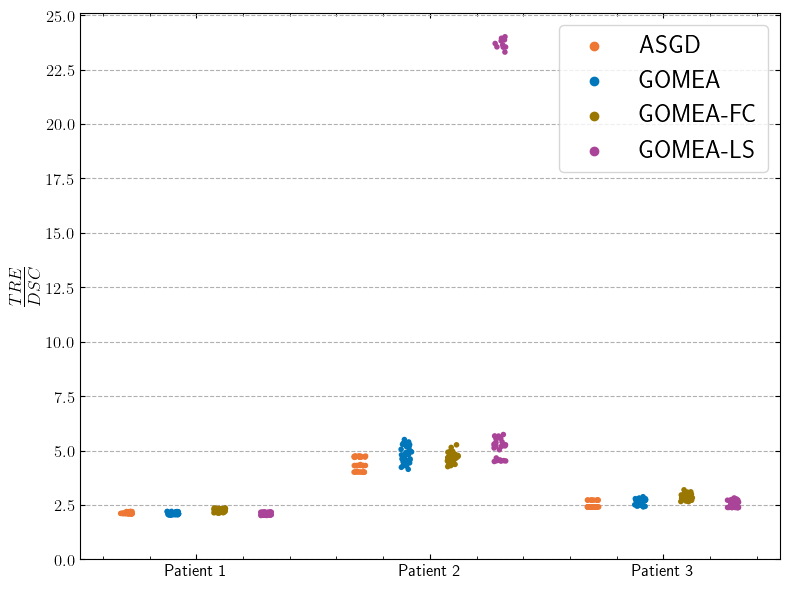

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))

aggregate_df = pd.concat(main_df_list)
sns.stripplot(data=aggregate_df, x="Instance", y="tre_dsc", hue="OptimizerName", dodge=True, size=4, ax=ax)

handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles, labels, ncol=1, loc="upper right", prop={'size': 18})

ax.set_ylabel("$\\frac{TRE}{DSC}$", fontsize=18)
ax.set_xlabel("")
ax.set_yticks([0 + 2.5 * i for i in range(11)])

fig.tight_layout()
# plt.savefig("stripplot.pdf")

In [16]:
from pymoo.indicators.hv import HV

hvs = []

for i, df_list in enumerate(df_lists):
    ref_point = [main_df_list[i]["metric0"].max()*0.8, main_df_list[i]["bending_energy_crude"].max()*1.2]
    print(f"Patient {i+1}, ref_point: {ref_point}")
    hvs_ = []
    for j, df in enumerate(df_list):
        A = df[["metric0", "bending_energy_crude"]].to_numpy()
        ind = HV(ref_point=ref_point)
        hv = ind(A)
        print(f"    HV {labels[j]}: {hv}")
        hvs_.append(hv)
    hvs.append(hvs_)

Patient 1, ref_point: [-0.6318878880000001, 0.4030669450486125]
    HV ASGD: 0.065346167241689
    HV GOMEA: 0.06971003247207078
    HV GOMEA-LS: 0.07041097280153608
    HV GOMEA-FC: 0.0650328097345771
Patient 2, ref_point: [-0.4833185280000001, 0.6448773272473093]
    HV ASGD: 0.14630184173962937
    HV GOMEA: 0.14561400675505717
    HV GOMEA-LS: 0.14911762234707326
    HV GOMEA-FC: 0.13075150674801161
Patient 3, ref_point: [-0.609392336, 0.5302849428180479]
    HV ASGD: 0.09268241639126273
    HV GOMEA: 0.09691772897784387
    HV GOMEA-LS: 0.09996064416480062
    HV GOMEA-FC: 0.08651257045298892


In [ ]:
from tabulate import tabulate
from scipy.stats import ttest_ind

rows = []
methods = ["ASGD", "GOMEA", "GOMEA-LS", "GOMEA-FC"]
metrics = ["tre", "dice_similarity", "bending_energy_crude"]

for i, df_list in enumerate(df_lists_mean):
    for j, df in enumerate(df_list):
        row = [f"& \\textit{{{methods[j]}}}"]
        df["tre_dsc"] = df["tre"] / df["dice_similarity"]
        df = df.sort_values(by="tre_dsc")
        df_std = df_lists_std[i][j]
        weight = df.index[0]
        for metric in metrics:
            mean = df[metric].iloc[0]
            std = df_std.loc[weight, metric]
            row.append(f"{mean:.2f} $\pm$ {std:.2f}")
        row.append(f"{hvs[i][j]:.2f}")
        rows.append(row)
print(tabulate(rows, headers=["X"]*5, tablefmt="latex_raw"))


In [2]:
# comparison dvfs
asgd_result = get_run_result("learn_1_fair_comparison_final", "1zvqaik8")
gomea_result = get_run_result("learn_1_fair_comparison_final", "2hjajlkj")

In [3]:
plt.close()

asgd_dvf = asgd_result.dvf
gomea_dvf = gomea_result.dvf
mask = asgd_result.instance.mask

bemap_asgd = bending_energy(asgd_dvf, downscaling_f=3, mask=mask, sum=False)
bemap_gomea = bending_energy(gomea_dvf, downscaling_f=3, mask=mask, sum=False)

mpl.rcParams['xtick.minor.visible'] = False; mpl.rcParams['ytick.minor.visible'] = False

computing bending energy: 100%|██████████| 31225/31225.0 [00:02<00:00, 12178.69it/s]
computing bending energy: 100%|██████████| 31225/31225.0 [00:02<00:00, 12110.21it/s]


/tmp/ipykernel_3186/1547423202.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


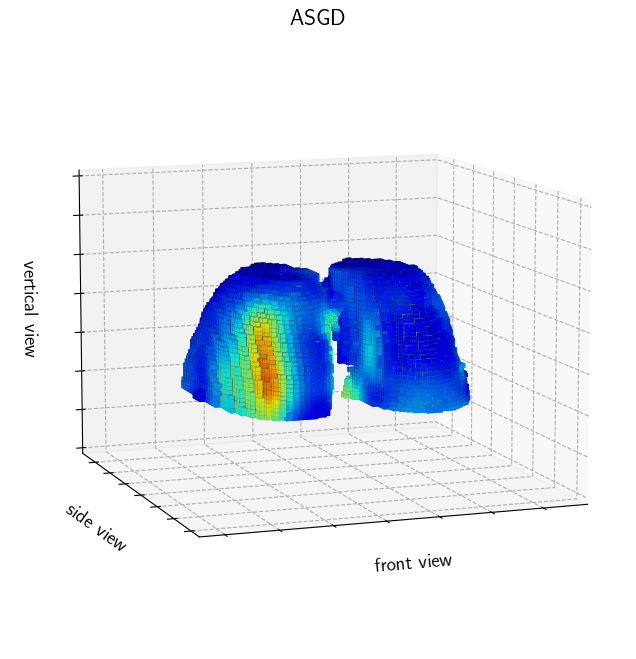

In [7]:
fig = plt.figure(figsize=(8, 8))
ax_asgd = fig.add_subplot(111, projection='3d')

bemap_asgd_swap = np.copy(np.swapaxes(bemap_asgd, 0, 2))
bemap_asgd_swap = bemap_asgd_swap / np.max(bemap_asgd_swap)

colors_asgd = plt.cm.jet(bemap_asgd_swap)
ax_asgd.voxels(bemap_asgd_swap, facecolors=colors_asgd, edgecolors=(0, 0, 0, 0.0))
ax_asgd.set_title("ASGD")

ax_asgd.view_init(10, -110);
ax_asgd.set_xlabel("front view"); ax_asgd.set_ylabel("side view"); ax_asgd.set_zlabel("vertical view")
ax_asgd.set_xticklabels([]); ax_asgd.set_yticklabels([]); ax_asgd.set_zticklabels([])

plt.tight_layout()
plt.savefig("bending_energy_map_asgd.pdf", bbox_inches='tight')

/tmp/ipykernel_3186/788353280.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


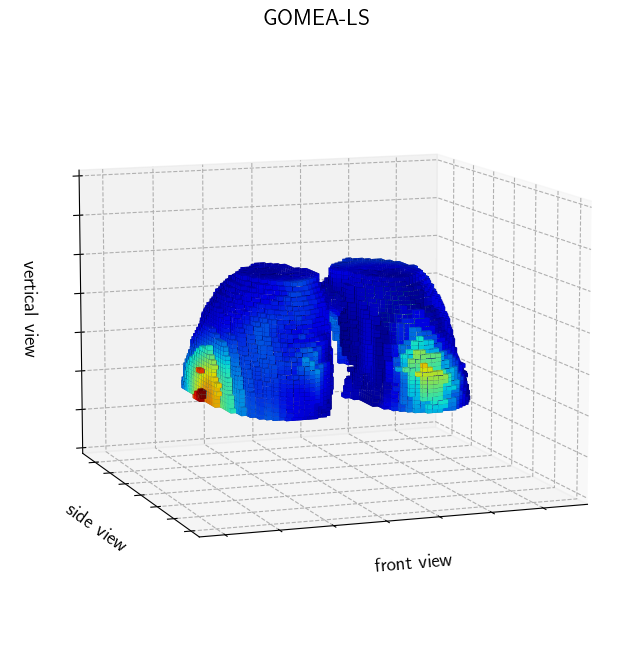

In [5]:
fig = plt.figure(figsize=(8, 8))
ax_gomea = fig.add_subplot(111, projection='3d')

bemap_gomea_swap = np.copy(np.swapaxes(bemap_gomea, 0, 2))
bemap_gomea_swap = bemap_gomea_swap / np.max(bemap_gomea_swap)

colors_gomea = plt.cm.jet(bemap_gomea_swap)
ax_gomea.voxels(bemap_gomea_swap, facecolors=colors_gomea, edgecolors=(0, 0, 0, 0.0))
ax_gomea.set_title("GOMEA-LS")

ax_gomea.view_init(10, -110);
ax_gomea.set_xlabel("front view"); ax_gomea.set_ylabel("side view"); ax_gomea.set_zlabel("vertical view")
ax_gomea.set_xticklabels([]); ax_gomea.set_yticklabels([]); ax_gomea.set_zticklabels([])

plt.tight_layout()
plt.savefig("bending_energy_map_gomea.pdf", bbox_inches='tight')

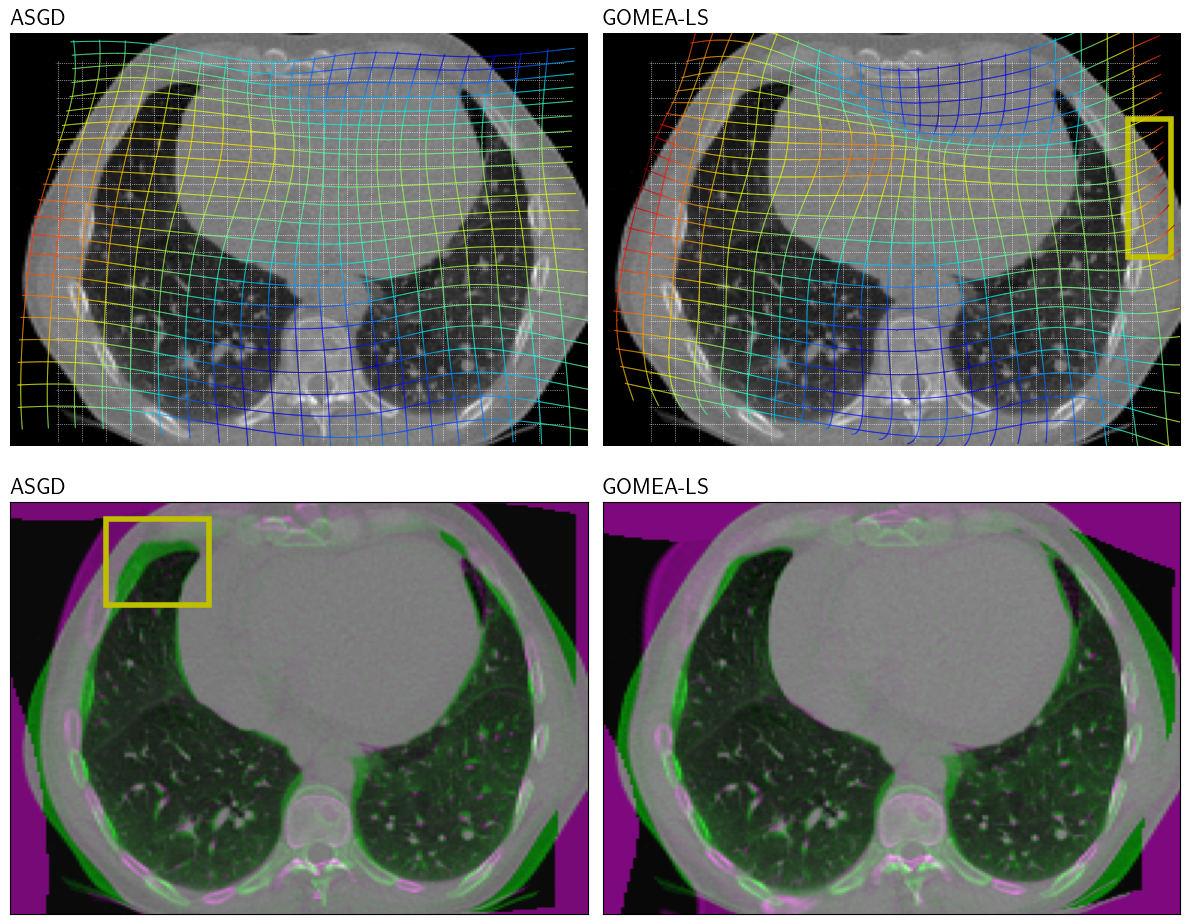

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
slice_tuple = (64, slice(None), slice(None))

_, (vmin, vmax) = plot_deformed_mesh(gomea_result, slice_tuple, ax=axes[0, 1], fix_axes=True)
plot_deformed_mesh(asgd_result, slice_tuple, ax=axes[0, 0], fix_axes=True, vmin=vmin, vmax=vmax)

plot_color_diff(gomea_result, slice_tuple, ax=axes[1, 1])
plot_color_diff(asgd_result, slice_tuple, ax=axes[1, 0])

axes[0, 1].add_patch(patches.Rectangle((-30, -190), 25, 80, linewidth=4, edgecolor='y', facecolor='none'))
axes[1, 0].add_patch(patches.Rectangle((220, 180), 60, 50, linewidth=4, edgecolor='y', facecolor='none'))

axes[0, 0].set_title("ASGD"); axes[0, 1].set_title("GOMEA-LS")
axes[1, 0].set_title("ASGD"); axes[1, 1].set_title("GOMEA-LS")

fig.tight_layout(h_pad=-10)
fig.savefig("slice_comparison_topdown.pdf", bbox_inches='tight')

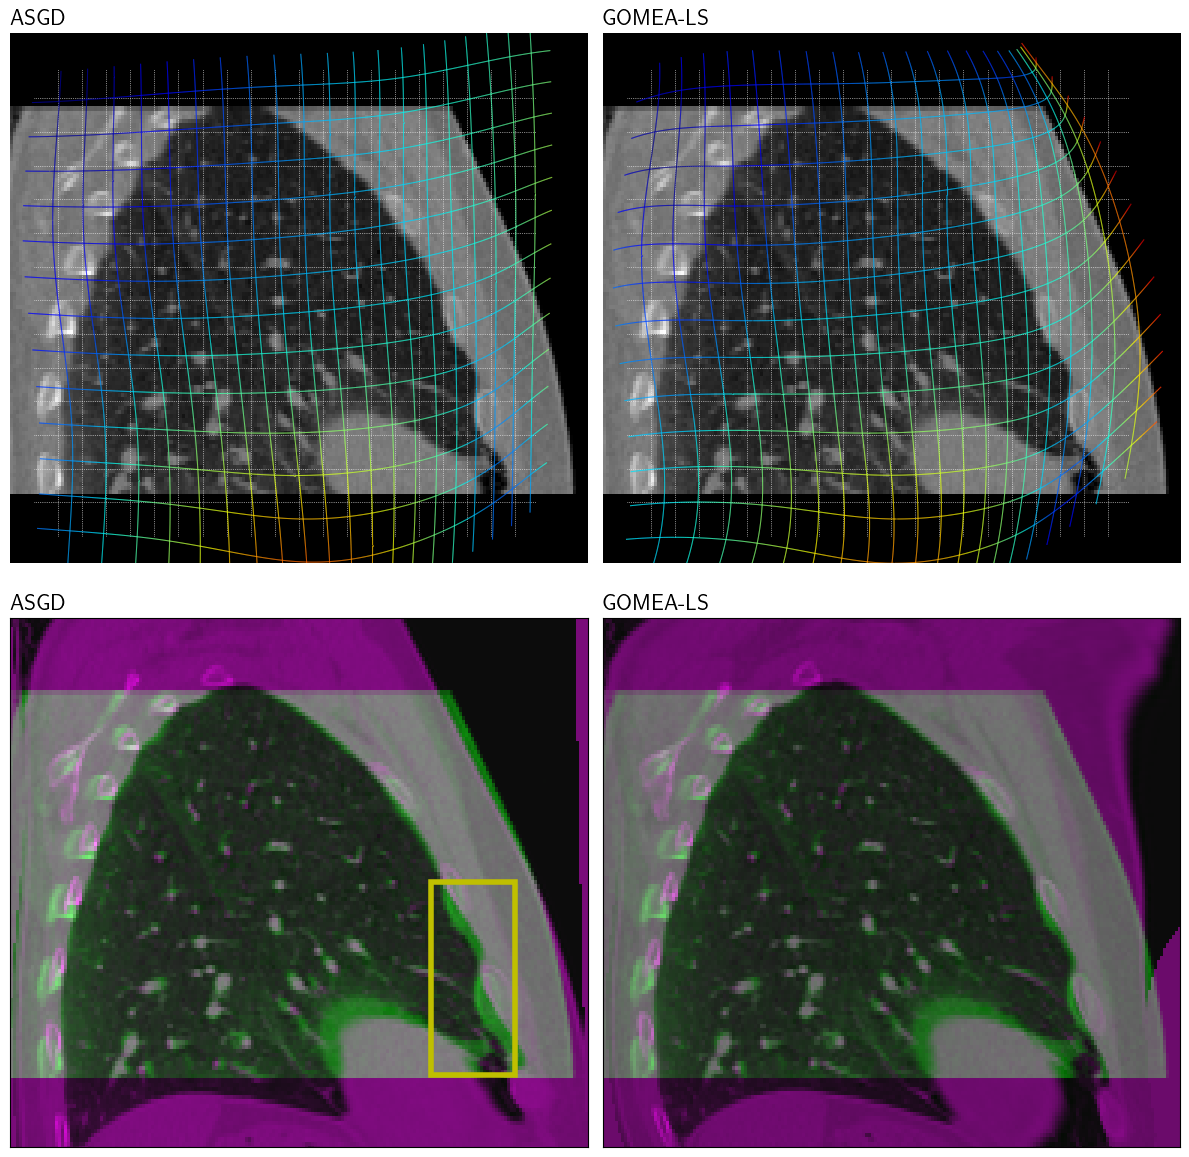

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
slice_tuple = (slice(None), slice(None), 40)

_, (vmin, vmax) = plot_deformed_mesh(gomea_result, slice_tuple, ax=axes[0, 1], fix_axes=True)
plot_deformed_mesh(asgd_result, slice_tuple, ax=axes[0, 0], fix_axes=True, vmin=vmin, vmax=vmax)

plot_color_diff(asgd_result, slice_tuple, ax=axes[1, 0])
plot_color_diff(gomea_result, slice_tuple, ax=axes[1, 1])

axes[1, 0].add_patch(patches.Rectangle((175, 110), 35, 80, linewidth=4, edgecolor='y', facecolor='none'))

axes[0, 0].set_title("ASGD"); axes[0, 1].set_title("GOMEA-LS")
axes[1, 0].set_title("ASGD"); axes[1, 1].set_title("GOMEA-LS")

fig.tight_layout()
fig.savefig("slice_comparison_side.pdf", bbox_inches='tight')